# Hybrid time series classification in aeon

The nature of the data and the problem dictate which category of algorithm is most appropriate. The most accurate algorithms on average, with no apriori knowledge of the best approach, combine multiple transformation types in a hybrid algorithm. We define a hybrid algorithm as one which by design encompasses or ensembles multiple of the discriminatory representations we have previously described. Some algorithms will naturally include multiple transformation characteristics, but are not classified as hybrid approaches. For example, many interval approaches extract unsupervised summary statistics from the intervals they select, but as the focus of the algorithm is on generating features from intervals we would not consider it a hybrid.


In [2]:
from aeon.datasets import load_basic_motions, load_italy_power_demand

X_train, y_train = load_italy_power_demand(split="train")
X_test, y_test = load_italy_power_demand(split="test")
X_test = X_test[:50]
y_test = y_test[:50]

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

X_train_mv, y_train_mv = load_basic_motions(split="train")
X_test_mv, y_test_mv = load_basic_motions(split="test")

print(X_train_mv.shape, y_train_mv.shape, X_test_mv.shape, y_test_mv.shape)

(67, 1, 24) (67,) (50, 1, 24) (50,)
(40, 6, 100) (40,) (40, 6, 100) (40,)


## The Hierarchical Vote Collective of Transformation Ensembles (HIVE-COTE)

HIVE-COTE are a family of algorithms that have been consistently the most
accurate approaches for TSC with the UCR data [1,2,3,4]. This first version of
HIVE-COTE, subsequently called HIVE-COTE$_\alpha$ (HC$_\alpha$) [2], is a heterogeneous
ensemble containing five modules each from a different representation: the Elastic
Ensemble from the distance based representation; Time Series Forest from interval based
methods; BOSS from dictionary based approaches, a version of the shapelet
transform classifier, ST-HESCA, from shapelet based techniques and the spectral based
RISE. The five modules are ensembled using the Cross-validation Accuracy Weighted
Probabilistic Ensemble (CAWPE, known at the time as HESCA) [5]. CAWPE employs a tilted
probability distribution using exponential weighing of probabilities estimated for
each module found through cross-validation on the train data. The weighted
probabilities from each module are summed and standardised to produce the HIVE-COTE
probability prediction. HC$_\alpha$ is not currently available in aeon, since it has
been superseeded by later versions.


## HIVE-COTE 1 (HC1)

Whilst state-of-the-art in terms of accuracy, HC$_\alpha$ scales poorly. A range of
improvements to make HIVE-COTE more usable were introduced in HIVE-COTE v1.0 (HC1) [3].
 HC1 has four modules: it drops the computationally intensive EE algorithm without
 loss of accuracy. BOSS is replaced by the more configurable cBOSS. The improved
 randomised version of STC is included with a default one hour shapelet search and
 the Rotation Forest classifier. TSF and RISE had usability improvements. HC1 is designed to be contractable, in that you can specify a maximum train time.

HC1 is available in aeon, but is only usable for univariate equal length problems,
and is not contractable, which makes it poor for small examples. We recommend using
HIVE-COTE v2, the latest version.


## HIVE-COTE V2
In 2021, HIVE-COTE was again updated to further address scalability issues and
reflect recent innovations to individual TSC representations and HIVE-COTE v2.0 (HC2)
[4] was proposed. In HC2, RISE, TSF and cBOSS are replaced,
with only STC retained. TDE replaces cBOSS as the
dictionary classifier. DrCIF replaces both TSF and RISE for the interval and
frequency representations. An ensemble of ROCKET classifiers called the Arsenal is
introduced as a new convolutional based approach. Estimation of test accuracy via
cross-validation is replaced by an adapted form of out-of-bag error, although the
final model is still built using all training data. Unlike previous versions, HC2 is
capable of classifying multivariate time series. HC2 is not designed to work really
quickly with small problems

<img src="./img/hc2.png" width="700" alt="HC2.">


In [4]:
from sklearn.metrics import accuracy_score

from aeon.classification.hybrid import HIVECOTEV1, HIVECOTEV2

hc1 = HIVECOTEV1()
hc2 = HIVECOTEV2(time_limit_in_minutes=0.2)
hc2.fit(X_train, y_train)
y_pred = hc2.predict(X_test)
accuracy_score(y_test, y_pred)

1.0

In [ ]:
hc2.fit(X_train_mv, y_train_mv)
y_pred = hc2.predict(X_test_mv)

accuracy_score(y_test_mv, y_pred)

## Performance on the UCR univariate datasets

You can find the hybrid based classifiers as follows. Note that we do not have a
TS-CHIEF implementation in aeon, but we have results from our java toolkit.

In [1]:
from aeon.registry import all_estimators

est = all_estimators("classifier", filter_tags={"algorithm_type": "hybrid"})
for c in est:
    print(c)

('HIVECOTEV1', <class 'aeon.classification.hybrid._hivecote_v1.HIVECOTEV1'>)
('HIVECOTEV2', <class 'aeon.classification.hybrid._hivecote_v2.HIVECOTEV2'>)
('RISTClassifier', <class 'aeon.classification.hybrid._rist.RISTClassifier'>)


In [2]:
from aeon.benchmarking import get_estimator_results_as_array
from aeon.datasets.tsc_datasets import univariate

names = [t[0] for t in est]
names.append("TS-CHIEF")  # TS-Chief is not available in aeon, results from a
# Java implementation

results, present_names = get_estimator_results_as_array(
    names, univariate, include_missing=False
)
results.shape

(112, 4)

(<Figure size 600x230 with 1 Axes>, <Axes: >)

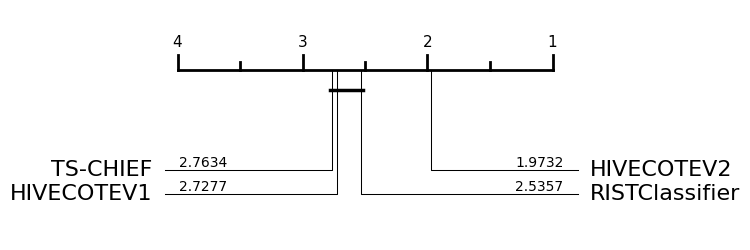

In [3]:
from aeon.visualisation import plot_boxplot_median, plot_critical_difference

plot_critical_difference(results, names)

(<Figure size 1000x600 with 1 Axes>, <Axes: >)

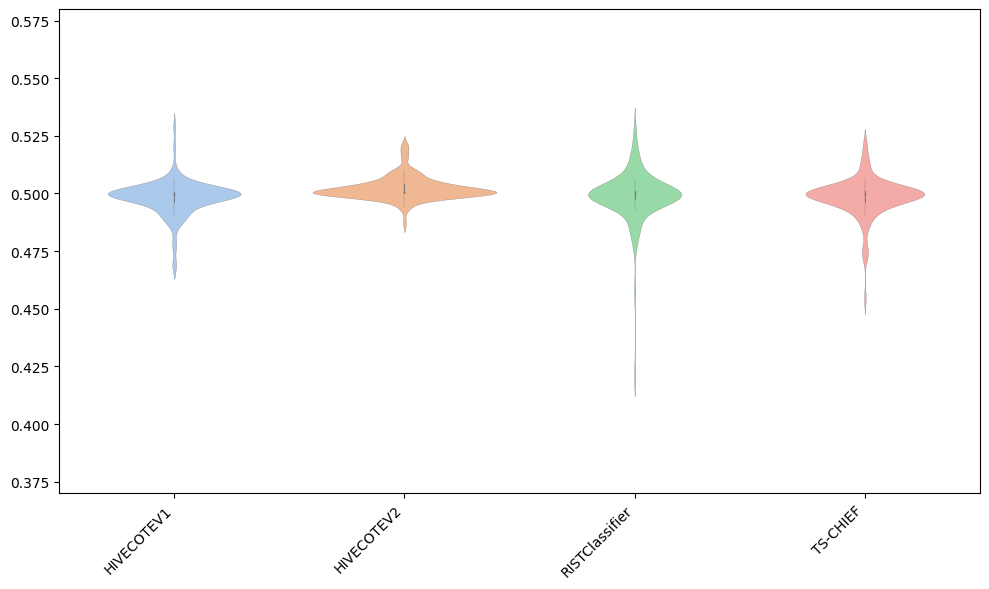

In [4]:
plot_boxplot_median(results, names)

## References
[1] Bagnall, Anthony, Jason Lines, Jon Hills and Aaron Bostrom. "Time-Series
Classification with COTE: The Collective of Transformation-Based Ensembles", in IEEE Transactions on Knowledge and Data Engineering, vol. 27, no. 9, 2015

[2] Lines, Jason, Sarqah Taylor and A. Bagnall. "Time Series Classification with
HIVE-COTE: The Hierarchical Vote Collective of Transformation-Based Ensembles". ACM
Transactions on Knowledge Discovery from Data. Volume 12 Issue 5, 2018
[ACM Trans] (https://dl.acm.org/doi/10.1145/3182382)

[3] Bagnall, Anthony, Michael Flynn, James Large, Jason Lines and Matthew Middlehurst
. "On the usage and performance of the Hierarchical Vote Collective of
Transformation-based Ensembles version 1.0 (hive-cote v1.0)" International Workshop
on Advanced Analytics and Learning on Temporal Data, 2020
[LNCS](https://link.springer.com/chapter/10.1007/978-3-030-65742-0_1)

[4] Middlehurst, Matthew, James Large, Michael Flynn, Jason Lines, Aaron Bostrom, and
 Anthony Bagnall. "HIVE-COTE 2.0: a new meta ensemble for time series classification
 ." Machine Learning, 2021
[ML 2021](https://link.springer.com/article/10.1007/s10994-021-06057-9)

[5] Large, James, Lines, Jason and Bagnall, Anthony. A probabilistic classifier
ensemble weighting scheme based on cross-validated accuracy estimates. Data Mining
and Knowledge Discovery volume 33, pages1674–1709, 2019
[DAMI](https://link.springer.com/article/10.1007/s10618-019-00638-y)

